In [1]:
import os


import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cudf
import cuml
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import train_test_split
from scipy.stats import randint
import pickle


In [11]:
#Import training data

path = r'/mnt/c/users/attic/hls_kelp/imagery/rf_training_V2'
files = os.listdir(path)
training_data = []
#file = 'HLS.L30.T11SKU.2018058T183349.v2.0_kelp_classified.tif'
for file in files:
    with rasterio.open(os.path.join(path, file)) as src:
            training_img = src.read()  
    file_data = training_img.reshape(training_img.shape[0], -1) 
    training_data.append(file_data)

combined_training_data = np.hstack(training_data)
combined_training_data[6,:] = combined_training_data[6,:]
print(combined_training_data.shape)
# plt.figure(figsize=(6, 6))
# plt.imshow(training_img[6,:], cmap='gray')
# plt.show()  



(7, 53582400)


In [3]:
print(combined_training_data)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 4 4 ... 4 4 4]]


In [12]:
df = cudf.DataFrame(combined_training_data.T)
X = df.iloc[:, :-1].astype('float32')
y = df.iloc[:, -1].astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Define cuML RF parameters
cu_rf_params = {
    'n_estimators':15,  # Increase number of trees
    'max_depth': 13,      # Increase maximum depth
    'n_bins': 20,         # Increase number of bins
    'n_streams': 16      # Adjust parallel streams based on GPU capability
}

# Initialize and fit the cuML RandomForestClassifier
cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)

# Optionally, you can predict and evaluate the model
y_pred = cu_rf.predict(X_test)

# Evaluate the model's performance (e.g., accuracy)
accuracy = cuml.metrics.accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.997361421585083


In [13]:
with open(r'/mnt/c/users/attic/hls_kelp/random_forest/cu_rf', 'wb') as f:
    pickle.dump(cu_rf, f)

In [14]:

# Read the raster file
with rasterio.open(r'/mnt/c/users/attic/hls_kelp/imagery/rf_training_V2/HLS.L30.T11SKU.2018058T183349.v2.0_kelp_classified.tif') as test:
    test_img = test.read()

# Reshape the data
test_data = test_img.reshape(test_img.shape[0], -1).T
test_data = test_data[:, 0:6]
test_data = test_data.astype('float32')
test_df = cudf.DataFrame(test_data)
y_pred = cu_rf.predict(test_df)
pred_shape = (test_img.shape[1], test_img.shape[2])
pred_img = y_pred.values_host.reshape(pred_shape)
print(pred_img.shape)

(3660, 3660)


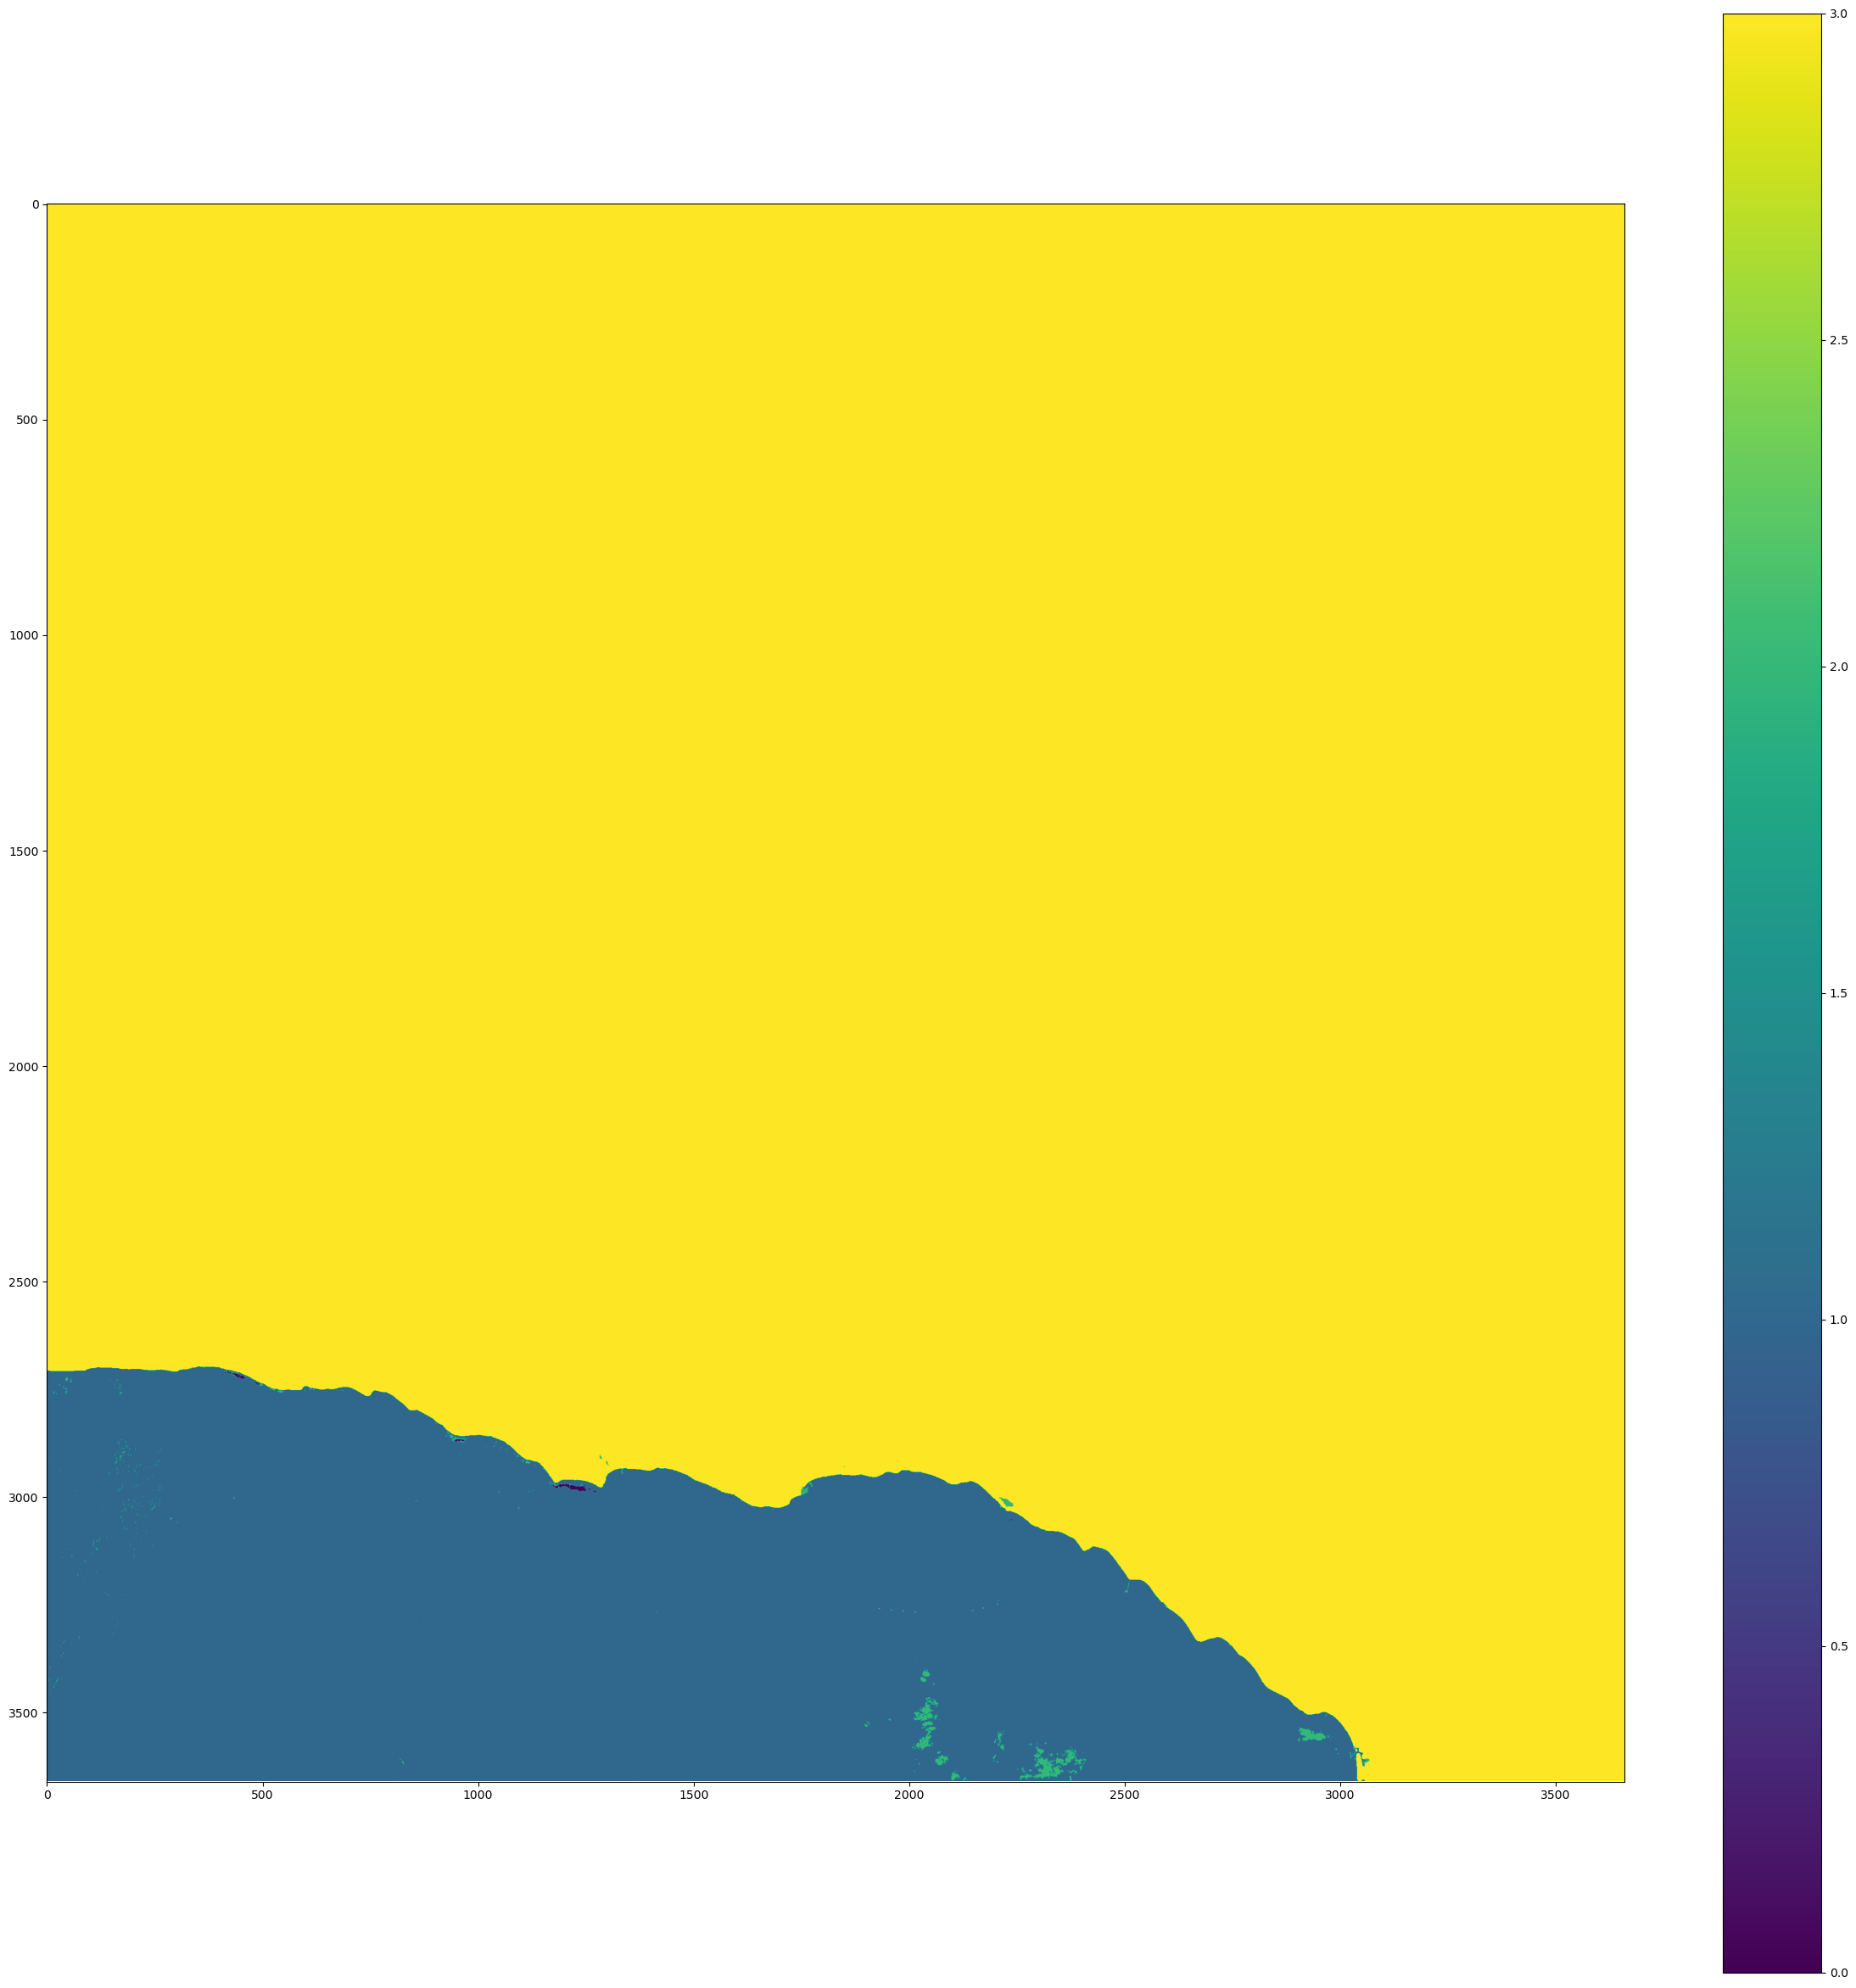

In [15]:

plt.figure(figsize=(30, 30))
plt.imshow(pred_img)
plt.colorbar()
plt.show()  

In [6]:
kelp_pred = cu_rf.predict(test_data)


[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]]


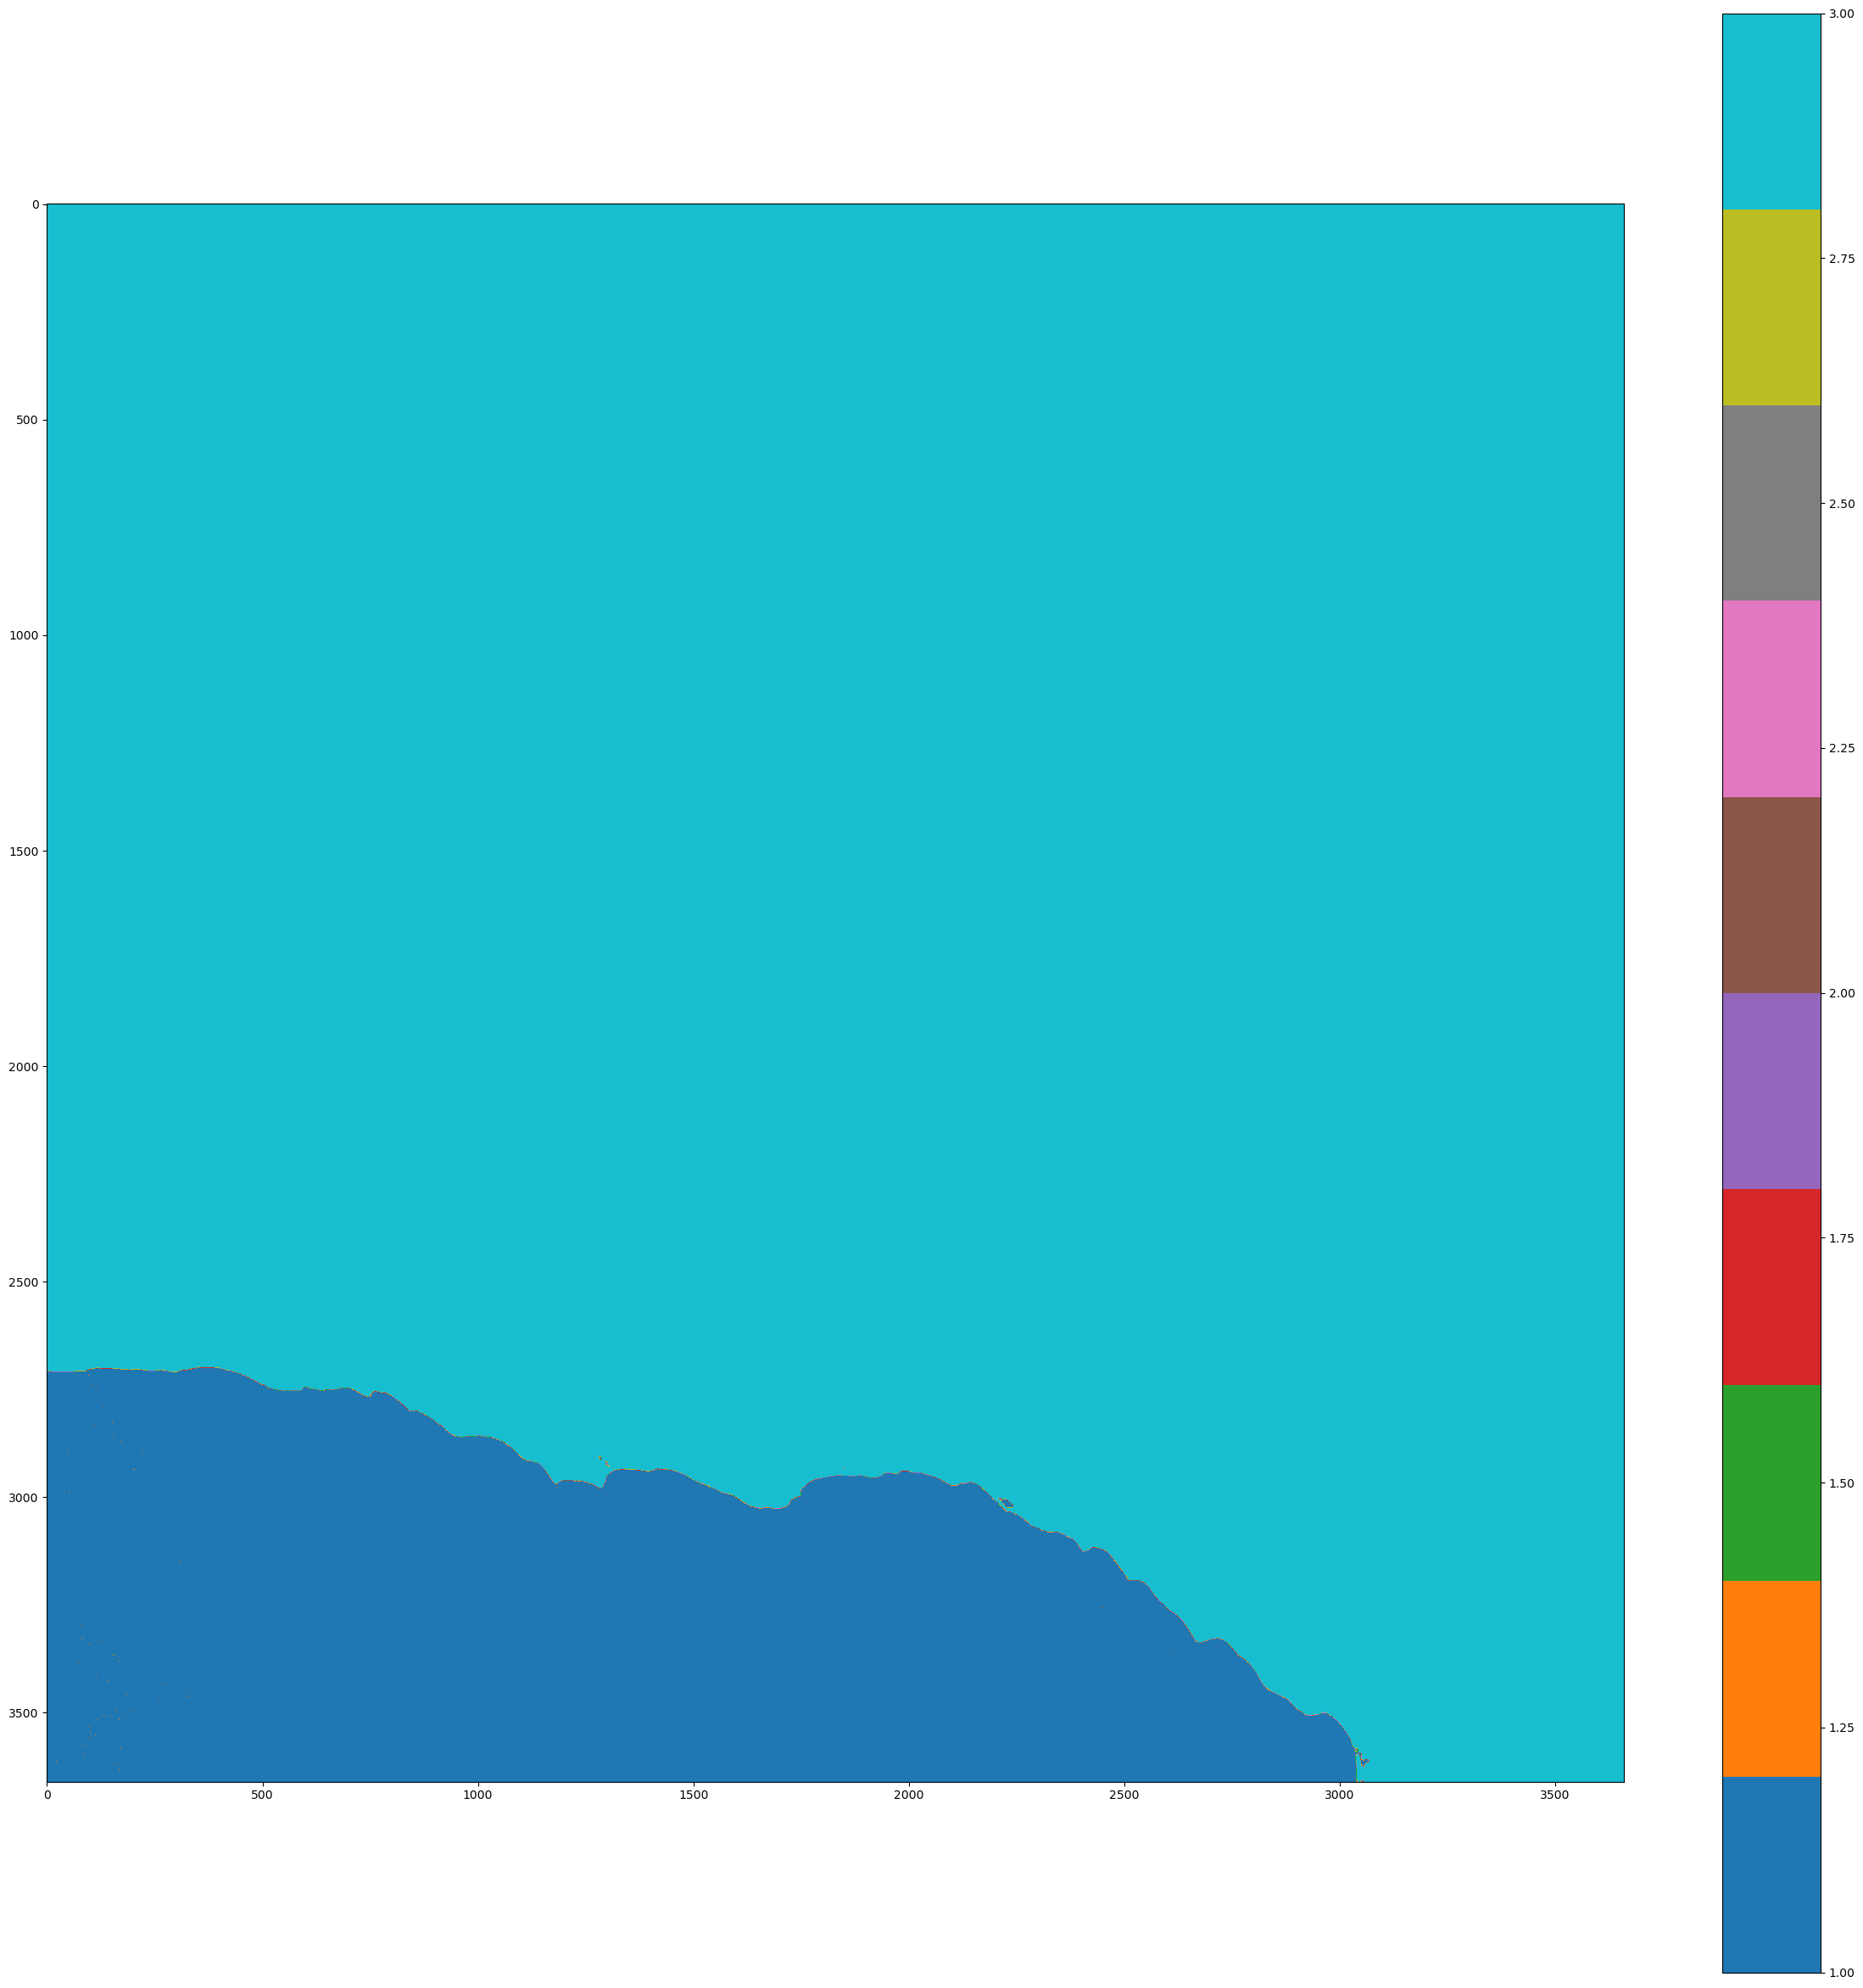

In [7]:
kelp_map = kelp_pred.reshape(3660,3660)
print(kelp_map)
plt.figure(figsize=(30, 30))
plt.imshow(kelp_map, cmap='tab10')
plt.colorbar()
plt.show()  